<a href="https://colab.research.google.com/github/JayantGoel001/GraphsAndSocialNetworkAnalytics/blob/master/Project/Link_Prediction_on_Facebook_Recruiting_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Link Prediction on Facebook Recruiting Dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
# Loading Training And Testing Dataset

!cp drive/MyDrive/Facebook.csv .

In [3]:
# Importing packages
import networkx as nx
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix,accuracy_score,f1_score
from xgboost import XGBClassifier


from time import time
from collections import Counter
import random
import os

In [4]:
df_train=pd.read_csv('Facebook.csv')
df_train.head()

,source_node,destination_node
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5


In [5]:
df_train.shape

(88234, 2)

In [6]:
print("Number of NUll Values in Training Data : ",sum(df_train.isna().any(1)))
print("Number of Duplicate Values in Training Data : ",sum(df_train.duplicated()))

Number of NUll Values in Training Data :  0
Number of Duplicate Values in Training Data :  0


In [7]:
edge_list = df_train.values.tolist()

In [8]:
G = nx.DiGraph(edge_list,nodetype=np.int32)

### Basic Information of graph.

In [9]:
nodes = G.nodes()
print("Number of Nodes : ",len(nodes))
print("Number of Edges : ",len(edge_list))

Number of Nodes :  4039
Number of Edges :  88234


# Reading 200 rows and Visualization

In [10]:
subgraph = nx.DiGraph(random.sample(edge_list,200),nodetype=np.int32)

DiGraph with 352 nodes and 200 edges


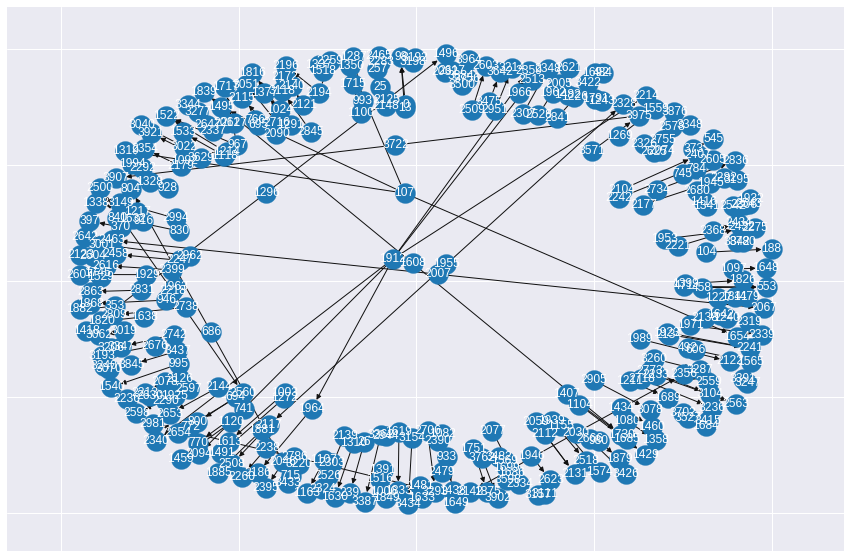

In [11]:
pos=nx.spring_layout(subgraph)
plt.figure(figsize=(15,10))
nx.draw_networkx(subgraph,pos,edge_color='#111',font_color='white',node_size=400)
plt.savefig("graph_sample.png")
print(nx.info(subgraph))

* inner nodes are source nodes and outer nodes are destination nodes.

In [12]:
dict_in = dict(G.in_degree())
dict_out = dict(G.out_degree())

indegree_dist = list(dict_in.values())
outdegree_dist = list(dict_out.values())

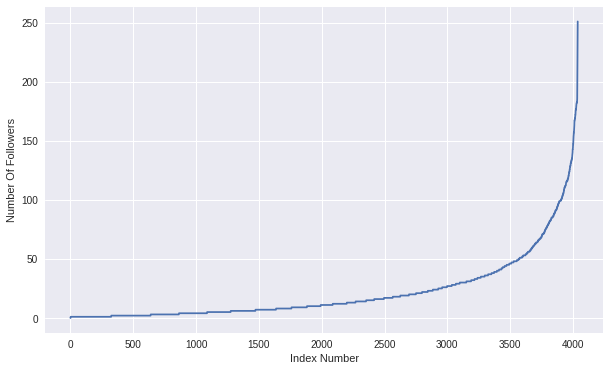

In [13]:
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index Number')
plt.ylabel('Number Of Followers')
plt.show()

* There are very less people having more followers. i.e. we have the data of common peoples

In [14]:
# 90-99 percentile
for i in range(0,10):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 55.0
91 percentile value is 59.0
92 percentile value is 64.0
93 percentile value is 70.0
94 percentile value is 78.0
95 percentile value is 85.0
96 percentile value is 94.0
97 percentile value is 103.0
98 percentile value is 117.0
99 percentile value is 141.85999999999967


In [15]:
# 99-100 percentile
for i in range(1,11,1):
    print(99+(i/10),'percentile value is',np.percentile(indegree_dist,99+(i/10)))

99.1 percentile value is 147.0
99.2 percentile value is 154.6959999999999
99.3 percentile value is 161.20199999999977
99.4 percentile value is 167.7720000000004
99.5 percentile value is 170.6199999999999
99.6 percentile value is 175.84799999999996
99.7 percentile value is 178.77199999999993
99.8 percentile value is 182.0
99.9 percentile value is 185.88600000000133
100.0 percentile value is 251.0


**Observation:**

* From 90 to 99 the people having less number of followers.
* From 99.1 to 99.9 the number of follower increases (very less number of peoples).

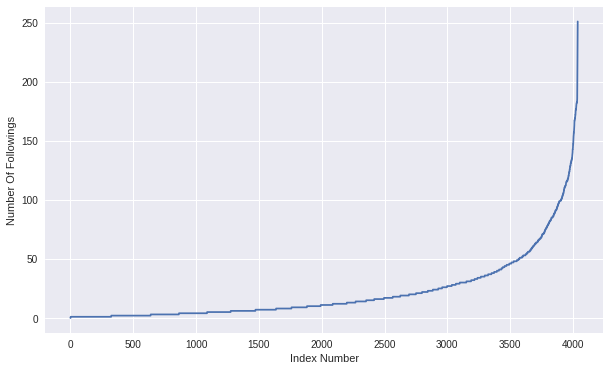

In [16]:
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index Number')
plt.ylabel('Number Of Followings')
plt.show()

* There are very less people having more followings.

In [17]:
# 90-99 percentile
for i in range(0,10):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 59.0
91 percentile value is 62.0
92 percentile value is 66.0
93 percentile value is 73.0
94 percentile value is 78.0
95 percentile value is 86.09999999999991
96 percentile value is 95.96000000000004
97 percentile value is 109.0
98 percentile value is 124.0
99 percentile value is 149.0


In [18]:
# 99-100 percentile
for i in range(1,11,1):
    print(99+(i/10),'percentile value is',np.percentile(outdegree_dist,99+(i/10)))

99.1 percentile value is 152.0
99.2 percentile value is 158.08799999999974
99.3 percentile value is 161.0
99.4 percentile value is 163.0
99.5 percentile value is 164.0
99.6 percentile value is 173.39199999999983
99.7 percentile value is 184.77199999999993
99.8 percentile value is 190.84799999999996
99.9 percentile value is 342.36400000005415
100.0 percentile value is 1043.0


In [19]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is', sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist))

No of persons those are not following anyone are 376 and % is 9.309234959148304


In [20]:
print('No of persons who have no followers' ,sum(np.array(indegree_dist)==0),'and % is',sum(np.array(indegree_dist)==0)*100/len(indegree_dist))

No of persons who have no followers 2 and % is 0.04951720722951226


**Observation**
* It indicates that there are many people who are not using or not active on social network.

In [21]:
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

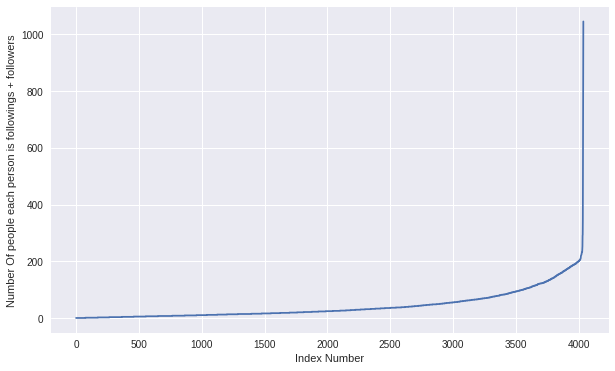

In [22]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index Number')
plt.ylabel('Number Of people each person is followings + followers')
plt.show()

In [23]:
# 90-99 percentile
for i in range(0,10):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 112.20000000000027
91 percentile value is 119.0
92 percentile value is 124.0
93 percentile value is 132.0
94 percentile value is 141.0
95 percentile value is 153.0999999999999
96 percentile value is 164.0
97 percentile value is 176.0
98 percentile value is 187.0
99 percentile value is 199.6199999999999


In [24]:
# 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 201.0
99.2 percentile value is 203.0
99.3 percentile value is 205.0
99.4 percentile value is 207.0
99.5 percentile value is 215.85999999999967
99.6 percentile value is 222.84799999999996
99.7 percentile value is 230.77199999999993
99.8 percentile value is 244.23999999999978
99.9 percentile value is 344.9860000000235
100.0 percentile value is 1045.0


# Generating missing edges from given graph

In [25]:
#the dict will contain a tuple of 2 nodes as key and the value will be 1 is the nodes are connected else -1
edges = dict()

for edge in edge_list: 
	edges[(edge[0], edge[1])] = 1 # if edge is present in r then 1.

# missing edges.
missing_edges = set([])

for a in range(1,len(nodes) + 1):
	for b in range(1,len(nodes) + 1):
		tmp = edges.get((a,b),-1)
		if tmp == -1 and a != b: # if edge is missing and a and b are not same.
			missing_edges.add((a,b))


In [26]:
len(missing_edges)

16221595

* positive -> connected nodes
* negative -> missing nodes

In [27]:
df_pos = df_train
df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])

print("Number of nodes in the graph with edges", df_pos.shape[0])
print("Number of nodes in the graph without edges", df_neg.shape[0])

Number of nodes in the graph with edges 88234
Number of nodes in the graph without edges 16221595


# Trian Test split 


In [28]:
X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)


print("Number of nodes in the Train data graph with edges", X_train_pos.shape[0]," : ",y_train_pos.shape[0])
print("Number of nodes in the Train data graph without edges", X_train_neg.shape[0]," : ", y_train_neg.shape[0])

print("Number of nodes in the Test data graph with edges", X_test_pos.shape[0]," : ",y_test_pos.shape[0])
print("Number of nodes in the Test data graph without edges", X_test_neg.shape[0]," : ",y_test_neg.shape[0])

Number of nodes in the Train data graph with edges 70587  :  70587
Number of nodes in the Train data graph without edges 12977276  :  12977276
Number of nodes in the Test data graph with edges 17647  :  17647
Number of nodes in the Test data graph without edges 3244319  :  3244319


In [29]:
X_train_pos.head()

,source_node,destination_node
17047,1029,1861
59352,2229,2556
40486,1929,2037
74983,2865,3196
4506,357,477


In [30]:
X_test_pos.head()

,source_node,destination_node
67299,2489,2624
59989,2243,2458
35473,1623,1810
73618,2803,2881
27849,1332,1606


In [31]:
y_train_pos

array([1., 1., 1., ..., 1., 1., 1.])

In [32]:
y_test_pos

array([1., 1., 1., ..., 1., 1., 1.])

Reading only the train positive (present edges) file

In [33]:
X_train = X_train_pos.append(X_train_neg,ignore_index=True)
y_train = np.concatenate((y_train_pos,y_train_neg))
X_test = X_test_pos.append(X_test_neg,ignore_index=True)
y_test = np.concatenate((y_test_pos,y_test_neg)) 

X_train.to_csv('train_X.csv',header=False,index=False)
X_test.to_csv('test_X.csv',header=False,index=False)
pd.DataFrame(y_train.astype(int)).to_csv('train_y.csv',header=False,index=False)
pd.DataFrame(y_test.astype(int)).to_csv('test_y.csv',header=False,index=False)

In [34]:
train_graph = nx.DiGraph(X_train_pos.values.tolist())

# Feature Engineering

1. Jaccard distance

\begin{equation}
Jaccard \space Distance = \frac{|X\cap Y|}{|{X \cup Y}|} 
\end{equation}

In [35]:
#for followings
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/ (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [36]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/(len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

2. Cosine distance

\begin{equation}
Cosine \space Distance = \frac{|X\cap Y|}{\sqrt{|X|\cdot|Y|}} 
\end{equation}

In [37]:
#for followings
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/(math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [38]:
# For Followers
def cosine_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/(math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

3. Page rank

    PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links. It was originally designed as an algorithm to rank web pages.

* We will use the mean pagerank as imputation.

In [39]:
pr = nx.pagerank(train_graph, alpha=0.85)

In [40]:
mean_pr=float(sum(pr.values())) / len(pr)

In [41]:
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

min 8.014650212967957e-05
max 0.009980057311561218
mean 0.0002487562189054724


4. Shortest path

    Compute shortest path lengths in the graph.

In [42]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

5. Weakly connected components

    Given a directed graph, a weakly connected component (WCC) is a subgraph of the original graph where all vertices are connected to each other by some path, ignoring the direction of edges

In [43]:
# Getting weekly connected edges from graph 
wcc = list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

6. Adar Index

$$Adar \space Index(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [44]:
# Adar index
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

7. Follow Back

    In Follow Back if source node is following to destination node and destination node is also follow back to source node that node we are keep in Follow Back feature.

In [45]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

8. Katz Centrality

$$Katz \space Centrality(x,y)=\sum_{i=1}^{\infty}\beta . A^{<i>}_{xy}|$$

In [46]:
katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)

In [47]:
mean_katz=float(sum(katz.values())) / len(katz)

In [48]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.014211872094836108
max 0.032894420295031486
mean 0.015632592851219578


9. HITS (Hyperlink-Induced Topic Search)

    It is also known as hubs and authorities. It is a link analysis algorithm that rates Web pages. A good hub represented a page that pointed to many other pages, and a good authority represented a page that was linked by many different hubs.

In [49]:
hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)

In [50]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min -6.19351335949466e-23
max 0.010465803001921225
mean 0.00024875621890547273


Sampling the dataset

In [51]:
filename = "train_X.csv"
n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
s = 100000 #desired sample size
skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))

In [52]:
filename = "test_X.csv"
n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
s = 50000 #desired sample size
skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))

In [53]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 13047863
Number of rows we are going to elimiate in train data are 12947863
Number of rows in the test data file: 3261966
Number of rows we are going to elimiate in test data are 3211966


In [54]:
df_final_train = pd.read_csv('train_X.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head()

Our train matrix size  (100001, 3)


,source_node,destination_node,indicator_link
0,1029,1861,1
1,1271,1833,1
2,2910,3033,1
3,2352,2404,1
4,500,507,1


In [55]:
df_final_test = pd.read_csv('test_X.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head()

Our test matrix size  (50001, 3)


,source_node,destination_node,indicator_link
0,2489,2624,1
1,1551,1845,1
2,2235,2327,1
3,1267,1339,1
4,1535,1813,1


In [56]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [57]:
df_final_train['num_followers_s'], df_final_train['num_followers_d'], df_final_train['num_followees_s'], df_final_train['num_followees_d'], df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)

In [58]:
df_final_test['num_followers_s'], df_final_test['num_followers_d'], df_final_test['num_followees_s'], df_final_test['num_followees_d'], df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)

In [59]:
#mapping jaccrd followers to train and test data
df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

#mapping jaccrd followees to train and test data
df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)


#mapping jaccrd followers to train and test data
df_final_train['cosine_followers'] = df_final_train.apply(lambda row:cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['cosine_followers'] = df_final_test.apply(lambda row:cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

#mapping jaccrd followees to train and test data
df_final_train['cosine_followees'] = df_final_train.apply(lambda row:cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['cosine_followees'] = df_final_test.apply(lambda row:cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

In [60]:
#mapping adar index on train
df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
#mapping adar index on test
df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

#mapping followback or not on train
df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)
#mapping followback or not on test
df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

#mapping same component of wcc or not on train
df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
##mapping same component of wcc or not on train
df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

#mapping shortest path on train 
df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
#mapping shortest path on test
df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

In [61]:
#page rank for source and destination in Train and Test
#if anything not there in train graph then adding mean page rank 
df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))

#Katz centrality score for source and destination in Train and test
#if anything not there in train graph then adding mean katz score
df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))

#Hits algorithm score for source and destination in Train and test
#if anything not there in train graph then adding 0
df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))

#Hits algorithm score for source and destination in Train and Test
#if anything not there in train graph then adding 0
df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))

In [62]:
df_final_train.head()

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,adar_index,follows_back,same_comp,shortest_path,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,1029,1861,1,7,80,57,1,2,1,0,0.017544,0,0,0.495778,0,1,2,0.000089,0.001152,0.014724,0.021409,4.089243e-07,4.527902e-09,3.669039e-08,2.396975e-07
1,1271,1833,1,32,146,50,8,23,3,0,0.054545,0,0,1.444159,0,1,2,0.000124,0.001370,0.016662,0.027359,1.848457e-07,1.086684e-07,1.229570e-07,4.914342e-07
2,2910,3033,1,33,41,34,30,14,13,0,0.254902,0,0,7.775159,0,1,2,0.000151,0.000219,0.016713,0.017441,1.112840e-11,9.343385e-12,2.845872e-11,3.118206e-11
3,2352,2404,1,80,94,54,45,51,28,0,0.394366,0,0,13.782659,0,1,2,0.000168,0.000271,0.021008,0.022482,4.200229e-03,3.532961e-03,5.845710e-03,6.134514e-03
4,500,507,1,37,35,28,12,14,6,0,0.176471,0,0,3.781692,0,1,2,0.000249,0.000290,0.017015,0.016909,2.836517e-09,4.960840e-10,5.231797e-09,4.705665e-09


In [63]:
df_final_test.head()

,source_node,destination_node,indicator_link,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,adar_index,follows_back,same_comp,shortest_path,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,2489,2624,1,72,141,20,7,45,3,0,0.125000,0,0,1.441060,0,1,2,0.000212,0.001474,0.020887,0.028047,1.766985e-03,5.854158e-04,4.769803e-03,7.592705e-03
1,1551,1845,1,77,80,54,1,18,1,0,0.018519,0,0,0.523976,0,1,2,0.000230,0.001521,0.020554,0.021404,2.833144e-07,3.082338e-09,3.282176e-07,2.533580e-07
2,2235,2327,1,24,55,32,38,17,10,0,0.166667,0,0,5.804093,0,1,2,0.000131,0.000192,0.016037,0.018619,1.499444e-04,3.689998e-04,2.106410e-04,4.475549e-04
3,1267,1339,1,26,20,63,64,9,28,0,0.282828,0,0,14.513898,0,1,2,0.000108,0.000104,0.016225,0.015778,3.261740e-07,2.278762e-07,1.278550e-07,1.111756e-07
4,1535,1813,1,32,116,22,16,24,5,0,0.151515,0,0,2.555578,0,1,2,0.000155,0.000973,0.016847,0.024523,1.588719e-07,2.050096e-07,1.531096e-07,4.128350e-07


In [64]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link', 'num_followers_s',
       'num_followers_d', 'num_followees_s', 'num_followees_d',
       'inter_followers', 'inter_followees', 'jaccard_followers',
       'jaccard_followees', 'cosine_followers', 'cosine_followees',
       'adar_index', 'follows_back', 'same_comp', 'shortest_path',
       'page_rank_s', 'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d',
       'authorities_s', 'authorities_d'],
      dtype='object')

# Target data

In [65]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

### Droping unwanted columns and target values

In [66]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

# Model: XGBoost Classification

In [67]:
tuned_params = {'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 200, 300, 400, 500], 'reg_lambda': [0.001, 0.1, 1.0, 10.0, 100.0]}
model = RandomizedSearchCV(XGBClassifier(), tuned_params, n_iter=15, scoring = 'roc_auc', n_jobs=-1)
model.fit(df_final_train,y_train) # actual data and actual prediction

RandomizedSearchCV(estimator=XGBClassifier(), n_iter=15, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'reg_lambda': [0.001, 0.1, 1.0, 10.0,
                                                       100.0]},
                   scoring='roc_auc')

In [68]:
model.best_estimator_

XGBClassifier(learning_rate=0.05, max_depth=2, n_estimators=300,
              reg_lambda=0.001)

# Test set

In [71]:
y_train_pred = model.predict(df_final_train)
y_test_pred = model.predict(df_final_test)

# F1 score

F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account.

In [72]:
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.7413043478260869
Test f1 score 0.5866050808314088


# Confusion metrics

In [73]:
confusion_matrix(y_test, y_test_pred).T

array([[49695,   133],
       [   46,   127]])

In [74]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


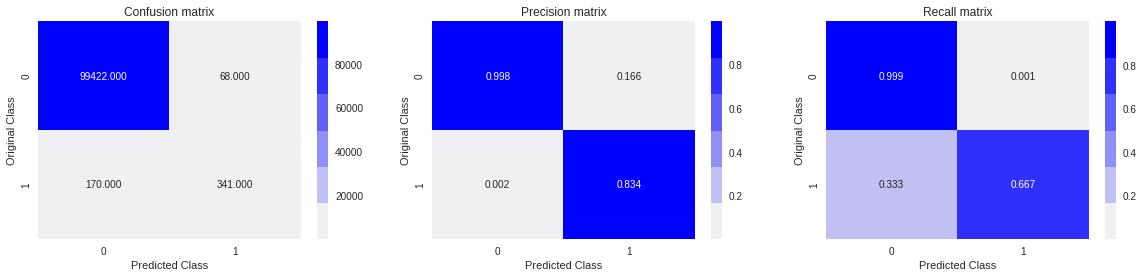

Test confusion_matrix


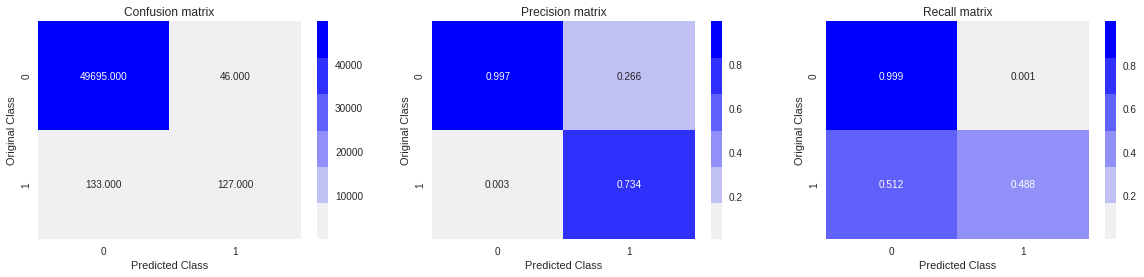

In [75]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

# ROC AUC

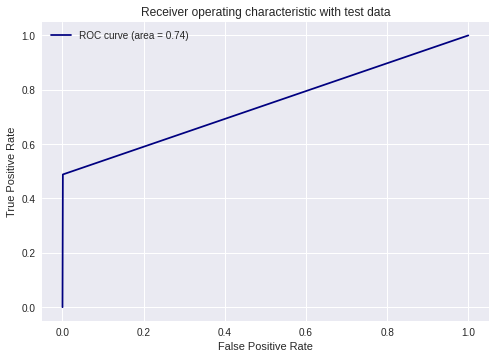

In [76]:
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

## Testing Accuracy

In [79]:
acc=accuracy_score(y_test,y_test_pred,normalize=True)*float(100)
print(acc)

99.6420071598568


## Training Accuracy

In [80]:
acc=accuracy_score(y_train,y_train_pred,normalize=True)*float(100)
print(acc)

99.7620023799762
